In [11]:
import os, sys

# Set working directory to your repo root
os.chdir("/kaggle/working/Flood-Monitoring")

# Add `src` to Python path so you can import src.* modules
sys.path.append(os.path.abspath("src"))

print("✅ Working dir:", os.getcwd())
print("✅ src in sys.path:", 'src' in sys.path[-1])


✅ Working dir: /kaggle/working/Flood-Monitoring
✅ src in sys.path: True


In [13]:
import yaml
from argparse import Namespace

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

hparams = Namespace(**config)

print("✅ Config loaded.")
print("🧠 Manifest path:", hparams.manifest_path)


✅ Config loaded.
🧠 Manifest path: data/processed/data_manifest.csv


In [14]:
import os
import pandas as pd

manifest_path = hparams.manifest_path

print("🔍 Checking file exists:", os.path.exists(manifest_path))
print("📁 Absolute path:", os.path.abspath(manifest_path))

# Try to load the CSV
df = pd.read_csv(manifest_path)
print("✅ Loaded manifest with shape:", df.shape)
df.head()


🔍 Checking file exists: True
📁 Absolute path: /kaggle/working/Flood-Monitoring/data/processed/data_manifest.csv
✅ Loaded manifest with shape: (900, 10)


,s1_vv,s1_vh,s2_b4_red,s2_b3_green,s2_b2_blue,s2_cloudmask,event,s1_chip_id,s2_chip_id,split
0,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,0c7daa97-37f6-4862-867f-b3843f298d9e,S1B_IW_GRDH_1SDV_20180507T151540_20180507T1516...,S2A_MSIL1C_20180505T070621_N0206_R106_T38NNK_2...,train
1,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,0c7daa97-37f6-4862-867f-b3843f298d9e,S1B_IW_GRDH_1SDV_20180507T151540_20180507T1516...,S2A_MSIL1C_20180505T070621_N0206_R106_T38NNK_2...,train
2,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,0c7daa97-37f6-4862-867f-b3843f298d9e,S1B_IW_GRDH_1SDV_20180507T151540_20180507T1516...,S2A_MSIL1C_20180505T070621_N0206_R106_T38NNL_2...,train
3,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,0c7daa97-37f6-4862-867f-b3843f298d9e,S1B_IW_GRDH_1SDV_20180507T151540_20180507T1516...,S2A_MSIL1C_20180505T070621_N0206_R106_T38NNK_2...,train
4,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,data/raw/data/c2s_ms_floods/chips/0c7daa97-37f...,0c7daa97-37f6-4862-867f-b3843f298d9e,S1B_IW_GRDH_1SDV_20180507T151540_20180507T1516...,S2A_MSIL1C_20180505T070621_N0206_R106_T38NNK_2...,train


In [20]:
import os

# Make sure parent directories exist before linking
os.makedirs("/kaggle/working/Flood-Monitoring/data/raw/data", exist_ok=True)
!ln -s /kaggle/input/sar-to-optical-flood-mapping/data/raw/data/c2s_ms_floods /kaggle/working/Flood-Monitoring/data/raw/data/c2s_ms_floods



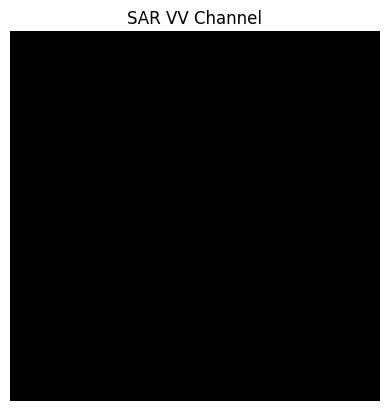

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "data/raw/data/c2s_ms_floods/chips/0c7daa97-37f6-4862-867f-b3843f298d9e/s1/S1B_IW_GRDH_1SDV_20180507T151540_20180507T151605_010817_013C63_FF38_03375-08316/VV.tif"
img = Image.open(img_path)

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("SAR VV Channel")
plt.show()


In [23]:
import torch
import yaml
from argparse import ArgumentParser, Namespace
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from lightning_module import SAR2OpticalGAN
from datamodule import SARDataModule

from model import UNetGenerator, PatchGANDiscriminator
from losses import PerceptualLoss, LSGANLoss, SpecklePreservationLoss, WaterIndexConsistencyLoss
import pytorch_lightning as pl

ImportError: cannot import name 'lee' from 'skimage.filters' (/usr/local/lib/python3.11/dist-packages/skimage/filters/__init__.py)

In [ ]:
def main(hparams):
    wandb_logger = WandBLogger(
        project=hparams.project_name,
        name=hparams.run_name,
    )

    wandb_logger.log_hyperparams(hparams)

    checkpoint_callback = ModelCheckpoint(
        dirpath=f"checkpoints/{hparams.run_name}",
        filename='{epoch:02d}-{val_psnr:.2f}',
        save_top_k=3,
        verbose=True,
        monitor='val/psnr', # Monitor a validation metric like PSNR
        mode='max'
    )
    lr_monitor = LearningRateMonitor(logging_interval='step')

    model = SAR2OpticalGAN(hparams)
    datamodule = SARDataModule(hparams)

    trainer = Trainer(
        max_epochs=hparams.max_epochs,
        logger=wandb_logger,
        callbacks=[checkpoint_callback, lr_monitor],
        accelerator=hparams.accelerator,
        devices=1,
        precision=hparams.precision,
        log_every_n_steps=hparams.log_every_n_steps,
    )
    trainer.fit(model, datamodule)

    wandb_logger.experiment.finish()




In [ ]:
if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, required=True, help='Path to the YAML configuration file.')
    args = parser.parse_args()


    with open(args.config, 'r') as f:
        config = yaml.safe_load(f)

    hparams = Namespace(**config)
    main(hparams)